<a href="https://www.advfn.com/nasdaq/nasdaq.asp?companies=A">Nasdaq Stocks</a>

In [1]:
!python3 best_stock_by_state.py
!say data ready

Current State: 1
n batches: 112
ZKID
Total DFs: 112
Complete. Data written to ../data/dar_by_state.csv


In [2]:
from datetime import datetime, timedelta

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import yfinance as yf

from best_stock_by_state import get_daily_returns

In [3]:
states = pd.read_csv('../data/hmm_exp_returns.csv')
states = states[['Date', 'state']]
states.index = pd.to_datetime(states.Date)
states.drop(columns='Date', inplace=True)
states.tail()

,state
Date,
2023-01-23,1
2023-01-24,1
2023-01-25,1
2023-01-26,1
2023-01-27,1


In [4]:
states.state.value_counts()

6    2855
2    2799
4    2250
0    1794
1    1591
5    1076
3     792
7     230
Name: state, dtype: int64

In [5]:
STATES = sorted(states.state.unique())
CURRENT_STATE = states.state.to_numpy()[-1]
CURRENT_STATE

1

In [6]:
TOMORROW = (datetime.now() + timedelta(1)).date()
YEARS_OF_DATA = 50
MIN_YEARS = 10
START = TOMORROW - timedelta(YEARS_OF_DATA * 365)

In [7]:
df = pd.read_csv('../data/dar_by_state.csv', index_col=0)
df.head()

,dar,dar_0,dar_1,dar_2,dar_3,dar_4,dar_5,dar_6,dar_7
APD,1.000503,0.995251,1.000316,1.001553,1.000323,1.001118,1.001227,1.001055,1.009547
APDN,0.998522,0.994982,0.995092,0.998543,0.998033,0.997524,0.997649,1.000331,0.998479
APEI,0.999834,0.996145,1.000661,0.999557,1.000234,1.000739,0.997568,1.001195,1.006065
APEN,0.998621,0.993802,1.000246,1.000579,1.000214,0.999288,0.997052,0.996516,1.004428
APH,1.000680,0.995047,1.000945,1.000851,1.000362,1.001765,1.002180,1.000791,1.014211


In [8]:
trans = pd.read_csv('../data/transition_probs.csv')
trans

,next_state,prob
0,0,0.019497
1,1,0.968553
2,2,0.008176
3,7,0.003774


In [9]:
trans.prob.sum()

0.9999999999999998

In [10]:
df['weighted'] = 0

for state, prob in zip(trans.next_state, trans.prob):
    df['weighted'] += prob * df[f'dar_{state}']

#if CURRENT_STATE == 0:
#    df['weighted'] = (
#        0.8*df[f'dar_{CURRENT_STATE}'] 
#        + 0.2*df[f'dar_{CURRENT_STATE + 1}'])
#elif CURRENT_STATE == 1:
#    df['weighted'] = (
#        0.6*df[f'dar_{CURRENT_STATE}']
#        + 0.2*df[f'dar_{CURRENT_STATE + 1}']
#        + 0.2*df[f'dar_{CURRENT_STATE - 1}'])
#elif CURRENT_STATE == 5:
#    df['weighted'] = (
#        0.6*df[f'dar_{CURRENT_STATE}']
#        + 0.2*df[f'dar_{CURRENT_STATE + 1}']
#        + 0.2*df[f'dar_{CURRENT_STATE - 1}'])
#elif CURRENT_STATE == ...
#elif CURRENT_STATE == 7:
#    df['weighted'] = (
#        0.8*df[f'dar_{CURRENT_STATE}']
#        + 0.2*df[f'dar_{CURRENT_STATE - 1}'])
df = df.sort_values('weighted', ascending=False)
df.head()

,dar,dar_0,dar_1,dar_2,dar_3,dar_4,dar_5,dar_6,dar_7,weighted
PALT,0.999875,0.997053,1.003693,0.998668,1.000478,1.000128,0.999427,1.001028,1.000078,1.003509
TRGP,1.001084,0.990762,1.003515,0.999576,0.999918,1.001864,1.003698,1.002267,1.011970,1.003266
CPRI,1.000320,0.985582,1.003557,0.999271,1.001834,1.001106,1.002307,1.000981,1.010271,1.003197
SIX,1.000646,0.990213,1.003285,1.002222,1.001235,1.000462,0.999422,1.000935,1.013380,1.003060
PED,0.997739,0.992979,1.003147,0.999951,0.995162,0.996496,1.005957,0.993171,1.012849,1.002959


In [11]:
df.mean(), df.median()

(dar         1.000114
 dar_0       0.994696
 dar_1       1.000292
 dar_2       1.000317
 dar_3       1.000980
 dar_4       1.001010
 dar_5       1.000944
 dar_6       1.000812
 dar_7       1.008193
 weighted    1.000213
 dtype: float64,
 dar         1.000294
 dar_0       0.994966
 dar_1       1.000397
 dar_2       1.000455
 dar_3       1.000941
 dar_4       1.001041
 dar_5       1.001150
 dar_6       1.000924
 dar_7       1.008386
 weighted    1.000331
 dtype: float64)

In [27]:
always_exclude = ['EP', 'NXN', 'NXP']
exclude = {
    0: [],
    1: ['ARCO', 'BWEN', 'EFXT', 'PALT', 'PED', 'VET'], #, 'BEEM', 'KOS', 'OMQS', 'POET', 'SLCA', 'MRC',  'SLCA'],
    2: ['FPAY', 'IOVA'],
    3: [],
    4: [],
    5: [],
    6: ['CENX', 'FTK', 'NOG', 'STCN'],
    7: []}

In [28]:
best_weighted = [
    s for s in df.index
    if s not in exclude[CURRENT_STATE] + always_exclude
][:20]

In [29]:
print(sorted(best_weighted))
#sorted(best_weighted)

['AMED', 'COOP', 'CPRI', 'CROX', 'CTSH', 'EPSN', 'FSI', 'FSLR', 'GGB', 'GTLS', 'HLIT', 'LFMD', 'MMYT', 'MPX', 'SIX', 'TGLS', 'TRGP', 'UI', 'VOC', 'WD']


In [30]:
data = (
    yf
    .download(best_weighted, start=START, end=TOMORROW)
    .rename(columns={'Adj Close': 'AdjClose'}))['AdjClose']

[*********************100%***********************]  20 of 20 completed


In [31]:
data.index = pd.to_datetime(data.index)
data = data.sort_index()
data.tail()

,AMED,COOP,CPRI,CROX,CTSH,EPSN,FSI,FSLR,GGB,GTLS,HLIT,LFMD,MMYT,MPX,SIX,TGLS,TRGP,UI,VOC,WD
Date,,,,,,,,,,,,,,,,,,,,
2023-01-23,95.860001,45.180000,64.410004,125.589996,64.239998,6.15,3.19,176.210007,6.29,131.279999,14.49,1.84,30.570000,13.45,27.190001,32.380001,75.599998,290.940002,10.81,93.970001
2023-01-24,91.519997,44.450001,64.019997,123.239998,63.919998,6.12,3.13,171.490005,6.32,128.330002,14.35,1.84,29.740000,13.23,27.320000,32.810001,75.089996,284.299988,10.05,92.059998
2023-01-25,92.080002,44.639999,63.669998,123.339996,64.139999,5.95,3.18,168.259995,6.39,125.440002,14.33,1.85,28.629999,13.20,27.209999,32.060001,75.309998,288.160004,10.16,92.199997
2023-01-26,91.160004,45.750000,64.150002,121.050003,64.660004,5.90,3.18,175.429993,6.55,128.490005,14.81,1.90,28.950001,12.99,27.150000,33.299999,76.050003,293.179993,10.83,93.940002
2023-01-27,93.180000,45.720001,64.639999,121.320000,65.709999,5.90,3.19,179.350006,6.35,127.830002,14.75,1.94,29.469999,12.85,27.260000,33.759998,75.349998,292.670013,10.52,94.519997


In [32]:
data = pd.concat([data, states], axis=1)

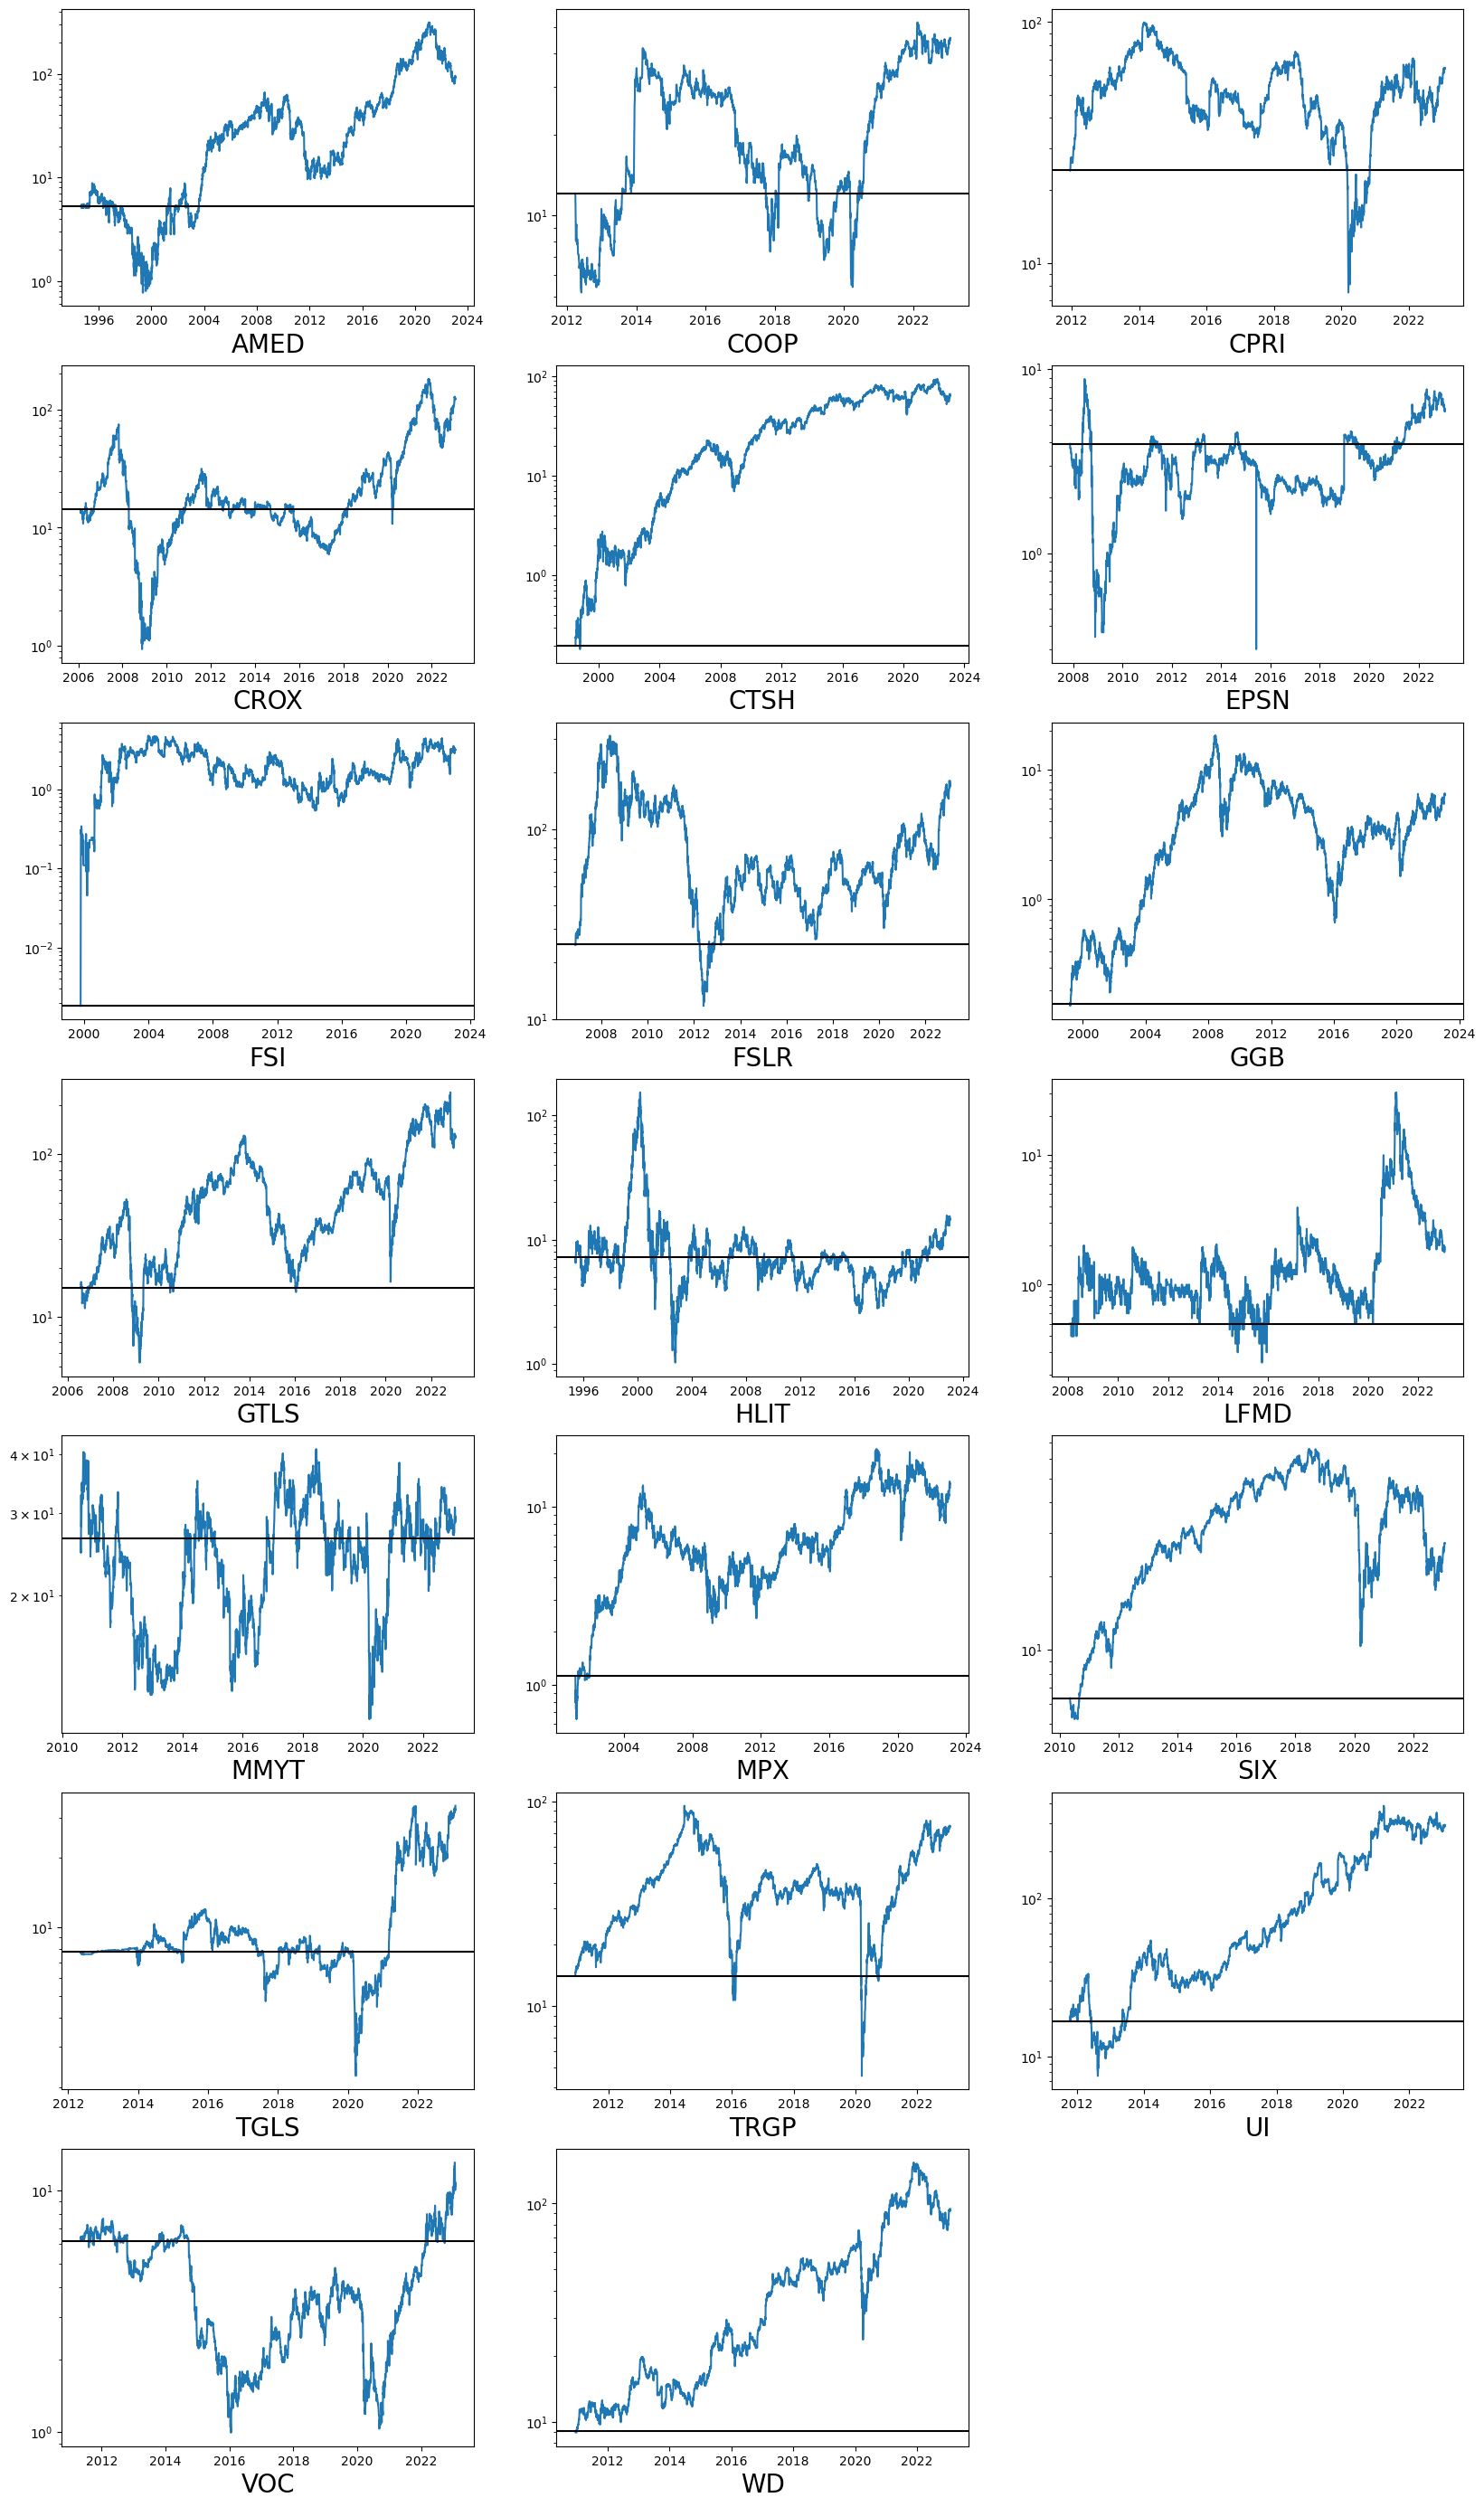

In [33]:
plt.rc('axes', labelsize=20)
plt.figure(figsize=[20, 35])
for i, sym in enumerate(list(data)):
    if sym == 'state':
        continue
    x = data[sym]
    x = x[x.notnull()]
    plt.subplot(7, 3, i + 1)
    plt.plot(x)
    plt.axhline(y=x[0], color='k')
    plt.xlabel(sym)
    plt.yscale('log');

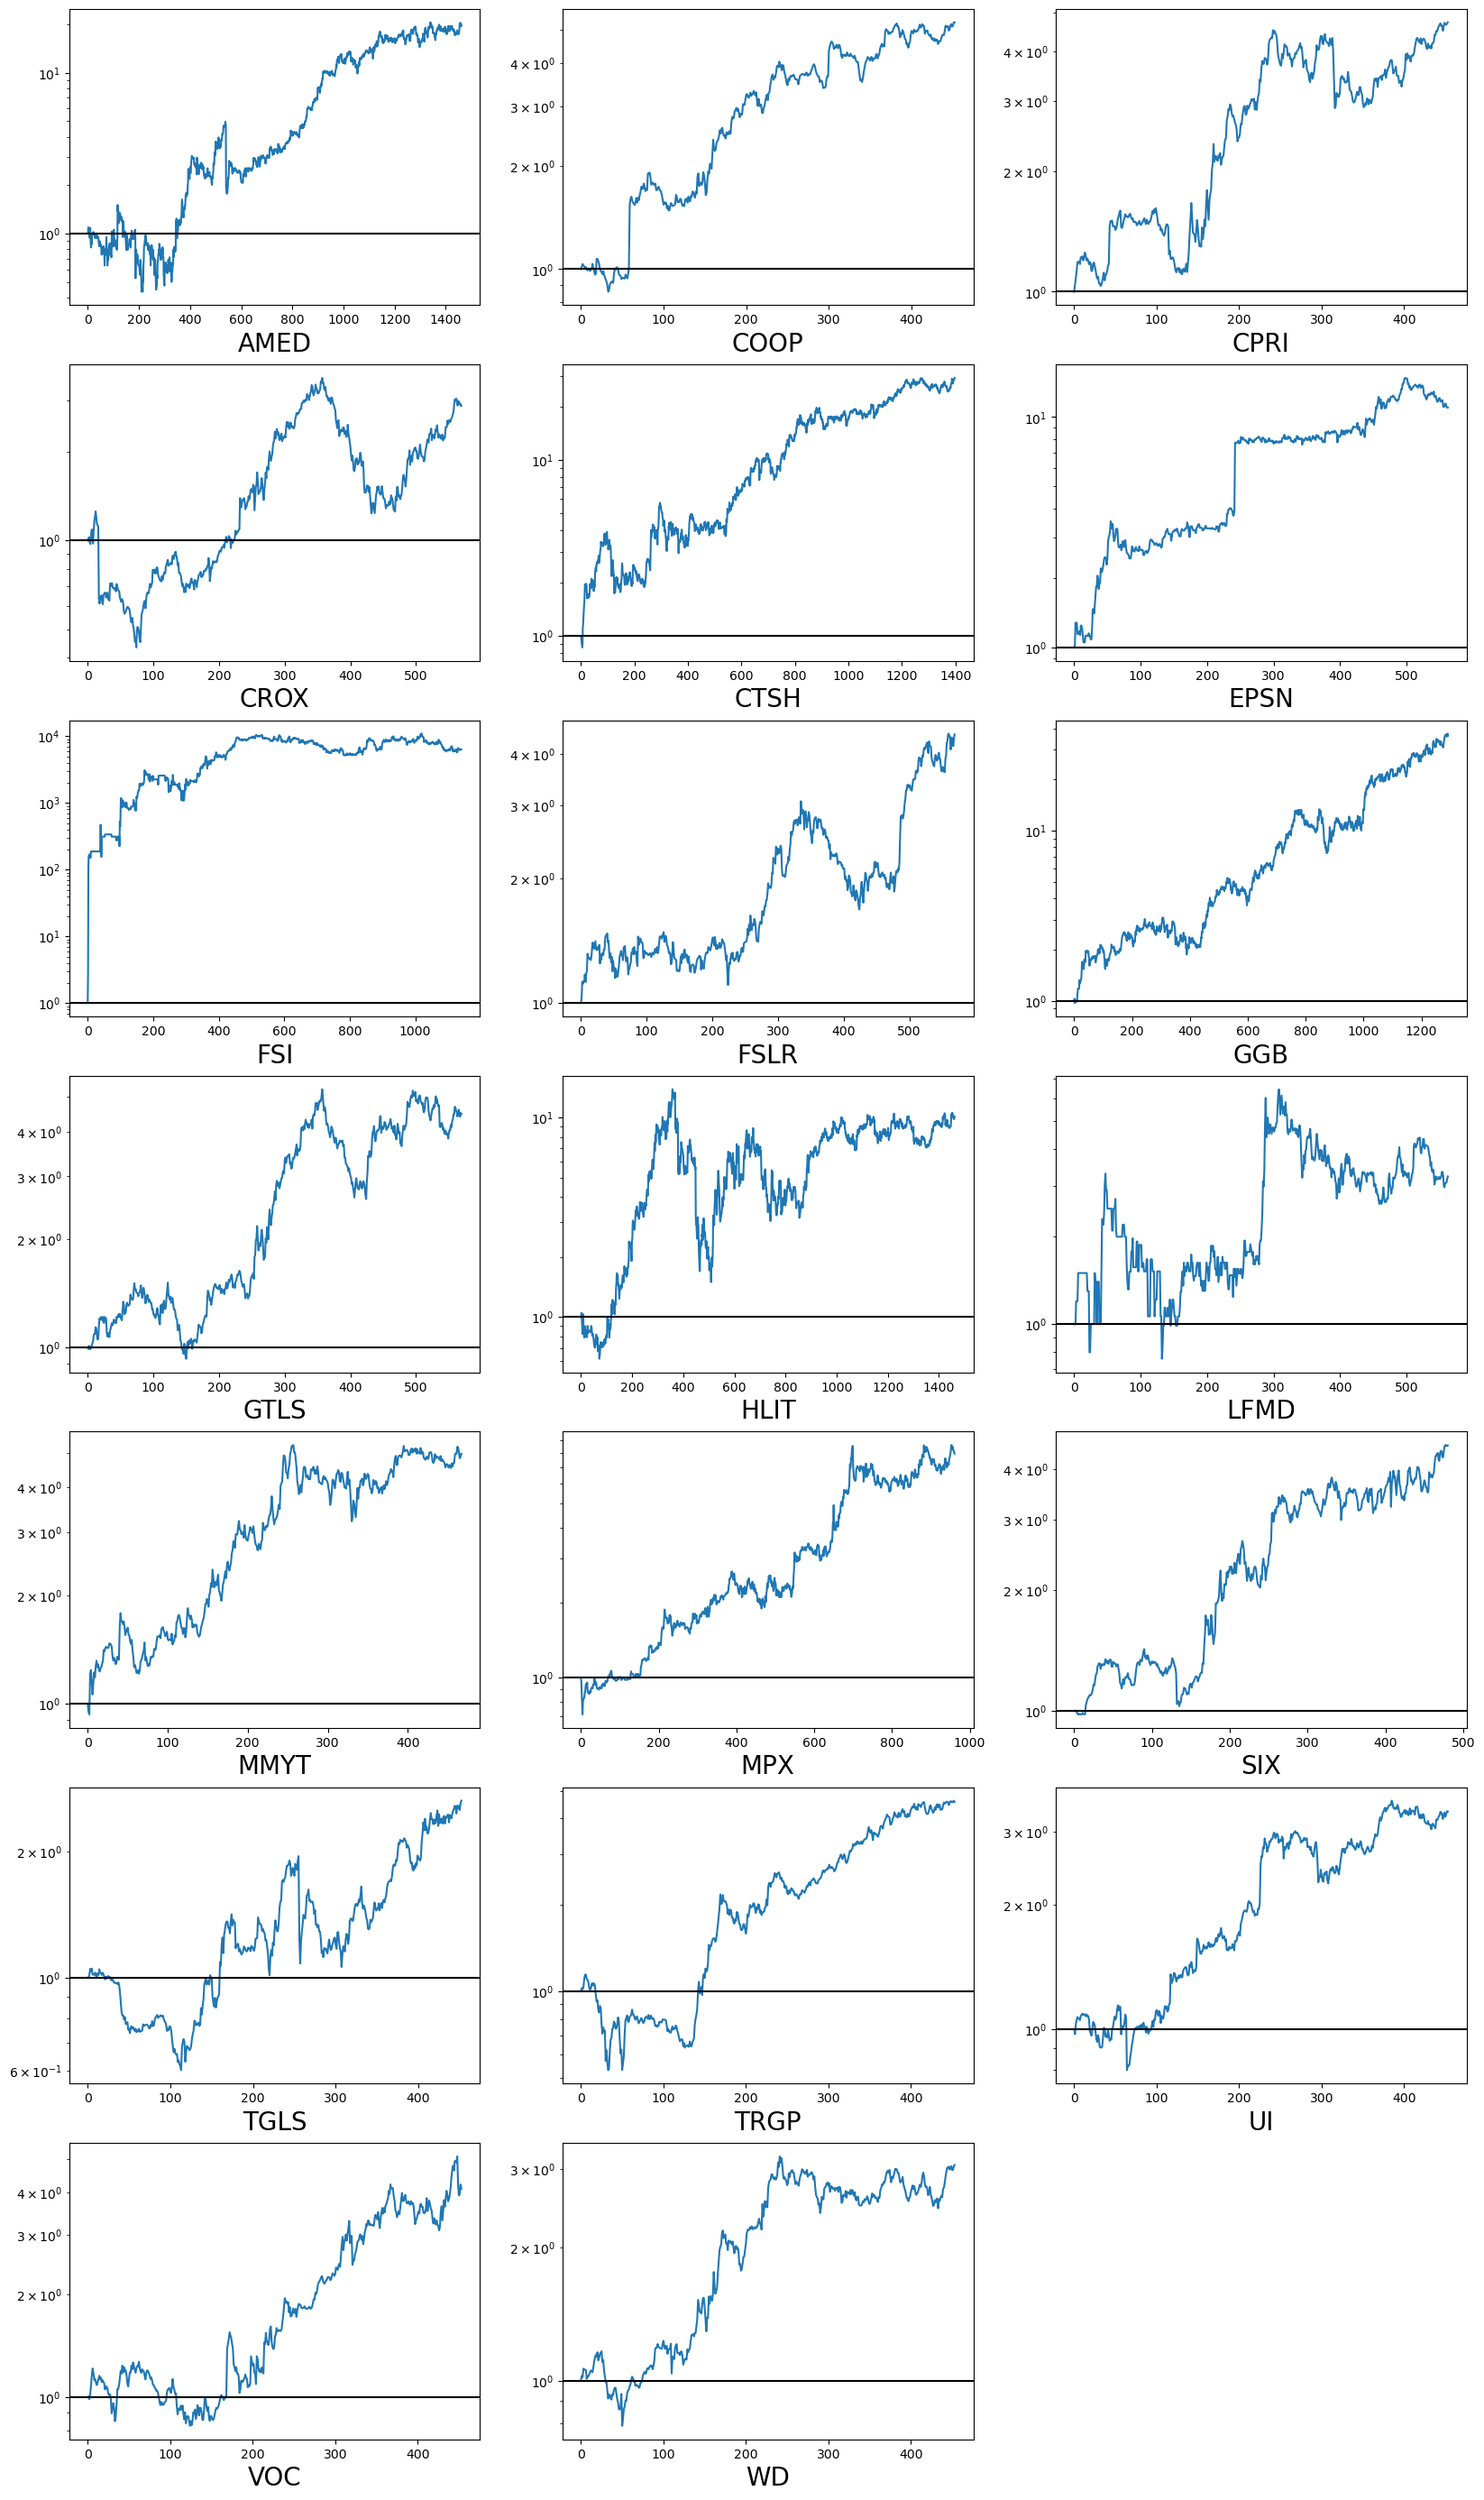

In [34]:
plt.figure(figsize=[20, 35])
for i, sym in enumerate(list(data)):
    if sym == 'state':
        continue
    plt.subplot(7, 3, i + 1)
    dr = get_daily_returns(data[sym])
    dr = dr[data.state == CURRENT_STATE]
    dr = dr[dr.notnull()]
    dr = (dr + 1).to_numpy()
    dr = np.array([1] + list(dr))
    plt.plot(dr.cumprod())
    plt.axhline(y=dr[0], color='k')
    plt.yscale('log')
    plt.xlabel(sym);

In [35]:
holdings = pd.read_csv(
    '~/Downloads/Holdings - Damian Satterthwaite-Phillips(1).csv',
    usecols=['Symbol', 'Value'],
    index_col=0
).rename(columns={'Value': 'holdings'})
holdings.holdings = holdings.holdings.apply(
    lambda x: round(float(x.replace('$', '').replace(',', ''))))
holdings.head()

,holdings
Symbol,
AMAT,3262
AMRC,3875
APPS,3905
BBY,3322
CEF,0


In [53]:
best_weighted = [
    s for s in df.index
    if s not in exclude[CURRENT_STATE] + always_exclude
][:10]

In [54]:
DOLLAR_AMT = 102_316 + 38_537
FRAC_IN = 0.7531
current = df.loc[best_weighted]
current['w'] = (current.weighted - 1) 
current.w = current.w / current.w.sum()
current['amt'] = (DOLLAR_AMT * FRAC_IN * current.w).round().astype(int)
current = pd.concat([current, holdings], axis=1)
current[['amt', 'holdings']] = current[['amt', 'holdings']].fillna(0).astype(int)
current['diff'] = current.amt - current.holdings
current.sort_values('diff')#.head(20)

,dar,dar_0,dar_1,dar_2,dar_3,dar_4,dar_5,dar_6,dar_7,weighted,w,amt,holdings,diff
ENPH,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,5462,-5462
DQ,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,4704,-4704
RFP,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,4484,-4484
CSIQ,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,4126,-4126
APPS,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,3905,-3905
AMRC,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,3875,-3875
SPLK,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,3716,-3716
TER,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,3620,-3620
COOP,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,3612,-3612
VTSI,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,3535,-3535
